In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import pyVIA.core as via
#print('pyVIA(Ver): ',via.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.5.3
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.7


2023-04-05 14:48:37.156881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 14:48:37.236061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 14:48:37.236095: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 14:48:37.737046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

/home/leihu/pyomic/lib/python3.8/site-packages/phate/__init__.py


In [2]:
from pyVIA.utils_via import *
from pyVIA.plotting_via import *
def draw_piechart_graph(adata,clusters,via_object, type_data='pt', gene_exp:list=[], title='', cmap:str=None, ax_text=True, dpi=150,headwidth_arrow = 0.1, alpha_edge=0.4, linewidth_edge=2, edge_color='darkblue',reference=None, show_legend:bool=True, pie_size_scale:float=0.8, fontsize:float=8):
    '''
    plot two subplots with a clustergraph level representation of the viagraph showing true-label composition (lhs) and pseudotime/gene expression (rhs)
    Returns matplotlib figure with two axes that plot the clustergraph using edge bundling
    left axis shows the clustergraph with each node colored by annotated ground truth membership.
    right axis shows the same clustergraph with each node colored by the pseudotime or gene expression
    :param via_object: is class VIA (the same function also exists as a method of the class and an external plotting function
    :param type_data: string  default 'pt' for pseudotime colored nodes. or 'gene'
    :param gene_exp: list of values (column of dataframe) corresponding to feature or gene expression to be used to color nodes at CLUSTER level
    :param title: string
    :param cmap: default None. automatically chooses coolwarm for gene expression or viridis_r for pseudotime
    :param ax_text: Bool default= True. Annotates each node with cluster number and population of membership
    :param dpi: int default = 150
    :param headwidth_bundle: default = 0.1. width of arrowhead used to directed edges
    :param reference: None or list. list of categorical (str) labels for cluster composition of the piecharts (LHS subplot) length = n_samples.
    :param pie_size_scale: float default=0.8 scaling factor of the piechart nodes
    :return: f, ax, ax1
    '''

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    f, ((ax, ax1)) = plt.subplots(1, 2, sharey=True, dpi=dpi)

    node_pos = via_object.graph_node_pos

    node_pos = np.asarray(node_pos)
    if cmap is None: cmap = 'coolwarm' if type_data == 'gene' else 'viridis_r'

    if type_data == 'pt':
        pt = via_object.scaled_hitting_times  # these are the final MCMC refined pt then slightly scaled at cluster level
        title_ax1 = "Pseudotime"

    if type_data == 'gene':
        pt = gene_exp
        title_ax1 = title
    if reference is None: reference_labels=via_object.true_label
    else: reference_labels = reference
    n_groups = len(set(via_object.labels))
    n_truegroups = len(set(reference_labels))
    group_pop = np.zeros([n_groups, 1])
    group_frac = pd.DataFrame(np.zeros([n_groups, n_truegroups]), columns=list(adata.obs[clusters].cat.categories))
    via_object.cluster_population_dict = {}
    for group_i in set(via_object.labels):
        loc_i = np.where(via_object.labels == group_i)[0]

        group_pop[group_i] = len(loc_i)  # np.sum(loc_i) / 1000 + 1
        via_object.cluster_population_dict[group_i] = len(loc_i)
        true_label_in_group_i = list(np.asarray(reference_labels)[loc_i])
        for ii in set(true_label_in_group_i):
            group_frac[ii][group_i] = true_label_in_group_i.count(ii)

    line_true = np.linspace(0, 1, n_truegroups)
    color_true_list = [plt.cm.rainbow(color) for color in line_true]
    color_true_list=adata.uns['{}_colors'.format(clusters)]

    sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
                     c='white', edgecolors='face', s=group_pop, cmap='jet')

    bboxes = getbb(sct, ax)

    ax = plot_edgebundle_viagraph(ax, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos, CSM=via_object.CSM,
                            velocity_weight=via_object.velo_weight, pt=pt, headwidth_bundle=headwidth_arrow,
                            alpha_bundle=alpha_edge,linewidth_bundle=linewidth_edge, edge_color=edge_color)

    trans = ax.transData.transform
    bbox = ax.get_position().get_points()
    ax_x_min = bbox[0, 0]
    ax_x_max = bbox[1, 0]
    ax_y_min = bbox[0, 1]
    ax_y_max = bbox[1, 1]
    ax_len_x = ax_x_max - ax_x_min
    ax_len_y = ax_y_max - ax_y_min
    trans2 = ax.transAxes.inverted().transform
    pie_axs = []
    pie_size_ar = ((group_pop - np.min(group_pop)) / (np.max(group_pop) - np.min(group_pop)) + 0.5) / 10  # 10

    for node_i in range(n_groups):

        cluster_i_loc = np.where(np.asarray(via_object.labels) == node_i)[0]
        majority_true = via_object.func_mode(list(np.asarray(reference_labels)[cluster_i_loc]))
        pie_size = pie_size_ar[node_i][0] *pie_size_scale

        x1, y1 = trans(node_pos[node_i])  # data coordinates
        xa, ya = trans2((x1, y1))  # axis coordinates

        xa = ax_x_min + (xa - pie_size / 2) * ax_len_x
        ya = ax_y_min + (ya - pie_size / 2) * ax_len_y
        # clip, the fruchterman layout sometimes places below figure
        if ya < 0: ya = 0
        if xa < 0: xa = 0
        rect = [xa, ya, pie_size * ax_len_x, pie_size * ax_len_y]
        frac = np.asarray([ff for ff in group_frac.iloc[node_i].values])

        pie_axs.append(plt.axes(rect, frameon=False))
        pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
        pie_axs[node_i].set_xticks([])
        pie_axs[node_i].set_yticks([])
        pie_axs[node_i].set_aspect('equal')
        # pie_axs[node_i].text(0.5, 0.5, graph_node_label[node_i])
        if ax_text==True: pie_axs[node_i].text(0.5, 0.5, majority_true, fontsize = fontsize )

    patches, texts = pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
    labels = list(set(reference_labels))
    if show_legend ==True: plt.legend(patches, labels, loc=(-5, -5), fontsize=6, frameon=False)

    if via_object.time_series==True:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)  +'knnseq_'+str(via_object.knn_sequential)# "+ is_sub
    else:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)
    ax.set_title(ti)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    title_list = [title_ax1]
    for i, ax_i in enumerate([ax1]):
        pt = via_object.markov_hitting_times if type_data == 'pt' else gene_exp

        c_edge, l_width = [], []
        for ei, pti in enumerate(pt):
            if ei in via_object.terminal_clusters:
                c_edge.append('red')
                l_width.append(1.5)
            else:
                c_edge.append('gray')
                l_width.append(0.0)

        gp_scaling = 1000 / max(group_pop)

        group_pop_scale = group_pop * gp_scaling * 0.5
        ax_i=plot_edgebundle_viagraph(ax_i, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos,CSM=via_object.CSM, velocity_weight=via_object.velo_weight, pt=pt,headwidth_bundle=headwidth_arrow, alpha_bundle=alpha_edge, linewidth_bundle=linewidth_edge, edge_color=edge_color)

        im1 = ax_i.scatter(node_pos[:, 0], node_pos[:, 1], s=group_pop_scale, c=pt, cmap=cmap,
                           edgecolors=c_edge,
                           alpha=1, zorder=3, linewidth=l_width)
        if ax_text:
            x_max_range = np.amax(node_pos[:, 0]) / 100
            y_max_range = np.amax(node_pos[:, 1]) / 100

            for ii in range(node_pos.shape[0]):
                ax_i.text(node_pos[ii, 0] + max(x_max_range, y_max_range),
                          node_pos[ii, 1] + min(x_max_range, y_max_range),
                          'C' + str(ii) + 'pop' + str(int(group_pop[ii][0])),
                          color='black', zorder=4, fontsize = fontsize)
        ax_i.set_title(title_list[i])
        ax_i.grid(False)
        ax_i.set_xticks([])
        ax_i.set_yticks([])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if type_data == 'pt':
        f.colorbar(im1, cax=cax, orientation='vertical', label='pseudotime',shrink=0.5)
    else:
        f.colorbar(im1, cax=cax, orientation='vertical', label='Gene expression',shrink=0.5)
    f.patch.set_visible(False)

    ax1.axis('off')
    ax.axis('off')
    ax.set_facecolor('white')
    ax1.set_facecolor('white')
    return f, ax, ax1

In [3]:
rna=sc.read('/home/leihu/data/analysis/rb_tutorial/data/analysis1/rna_anno.h5ad')
rna

AnnData object with n_obs × n_vars = 20105 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'dendrogram_leiden', 'dendrogram_

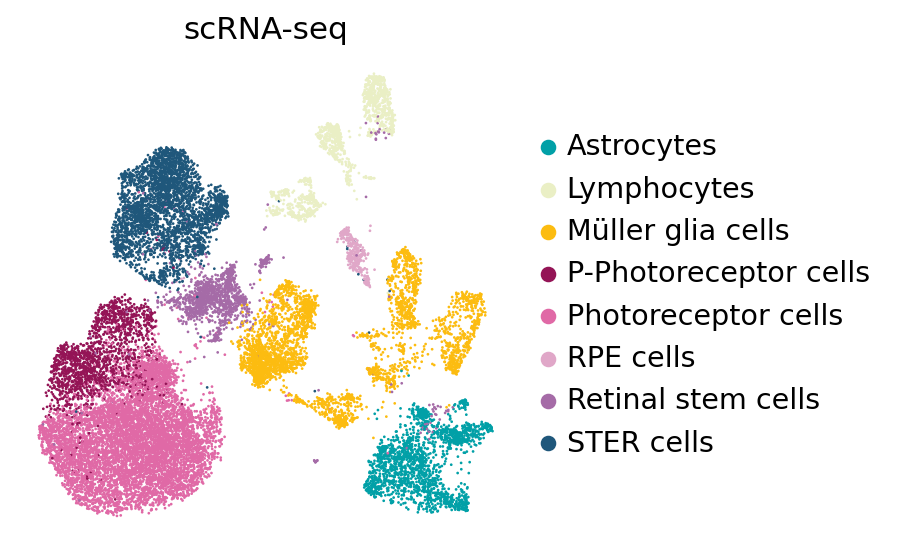

In [5]:
ax=sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype'],
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)
#plt.savefig('result_4/all_celltype1.png',dpi=300,bbox_inches='tight')

In [11]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Müller glia cells',#Germ-cell(Oid)
     '3': 'Photoreceptor cells',#Germ-cell(Oid)
     '4': 'STER cells',
     '5': 'Astrocytes',
     '6': 'Retinal stem cells',
     '7': 'Photoreceptor progenitor cell',
     '8': 'STER cells',
     '9': 'Photoreceptor cells',
     '10': 'Astrocytes',#Germ-cell(Oid)
     '11': 'Photoreceptor progenitor cell',
     '12': 'Müller glia cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'STER cells',#Germ
     '16': 'Photoreceptor cells',#plasma
     '17': 'Lymphocytes',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)
     '21': 'STER cells',
     '22': 'Müller glia cells',
     '23': 'Müller glia cells',



}
rna.obs['major_celltype'] = rna.obs['leiden'].map(cluster2annotation).astype('category')

In [7]:
rna.obs['major_celltype_new']=rna.obs['major_celltype']
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('str')
rna.obs.loc[rna.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
rna.obs.loc[rna.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
rna.obs.loc[rna.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('category')

In [8]:
rna.obs['major_celltype_new'].unique()

['Müller glia cells', 'Photoreceptor cells', 'Astrocytes', 'STER cells', 'Lymphocytes', 'RPE cells', 'Retinal stem cells', 'P-Photoreceptor cells']
Categories (8, object): ['Astrocytes', 'Lymphocytes', 'Müller glia cells', 'P-Photoreceptor cells', 'Photoreceptor cells', 'RPE cells', 'Retinal stem cells', 'STER cells']

In [9]:
adata=rna[rna.obs['major_celltype_new'].isin(['Müller glia cells', 'Astrocytes','Lymphocytes','RPE cells'])]
adata

View of AnnData object with n_obs × n_vars = 6677 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'den

In [10]:
sc.tl.pca(adata, n_comps=100, svd_solver="arpack")

#scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype','leiden','Type'])

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)


In [12]:
sc.pp.neighbors(adata, use_rep="X_pca", metric="cosine",n_neighbors=100, random_state = 112)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga')
#sc.pl.umap(adata,color='leiden')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


In [13]:
adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index

CategoricalIndex(['12', '13'], categories=['0', '1', '2', '3', ..., '10', '11', '12', '13'], ordered=False, dtype='category')

In [14]:
adata=adata[~adata.obs['leiden'].isin(adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index)]
adata

View of AnnData object with n_obs × n_vars = 6614 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'den

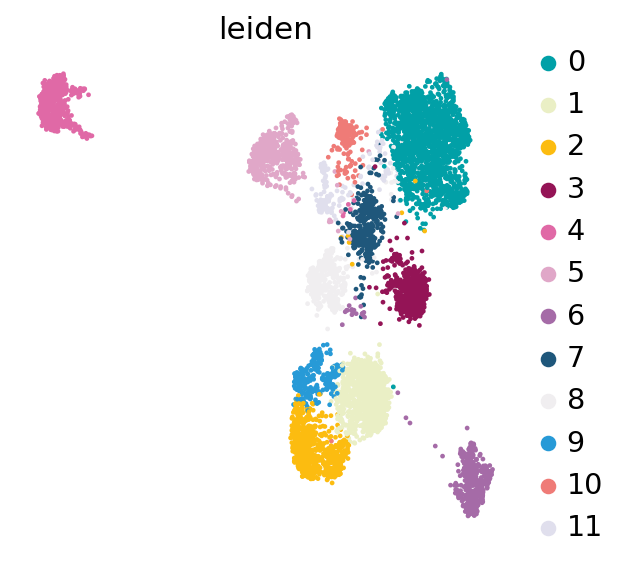

In [15]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['leiden'],
    title='leiden',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

In [16]:
scv.tl.recover_dynamics(adata,n_jobs=10)

recovering dynamics (using 10/12 cores)


  0%|          | 0/469 [00:00<?, ?gene/s]

    finished (0:00:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [17]:
scv.tl.velocity(adata, mode='dynamical',show_progress_bar=False)
scv.tl.velocity_graph(adata,n_jobs=10)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/12 cores)


  0%|          | 0/6614 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


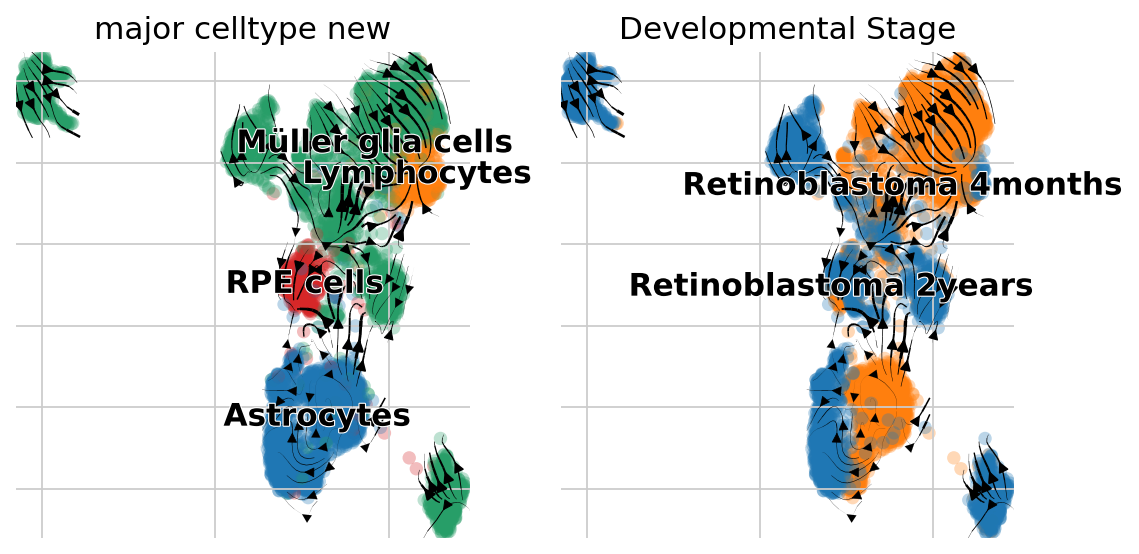

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype_new','Developmental_Stage'])

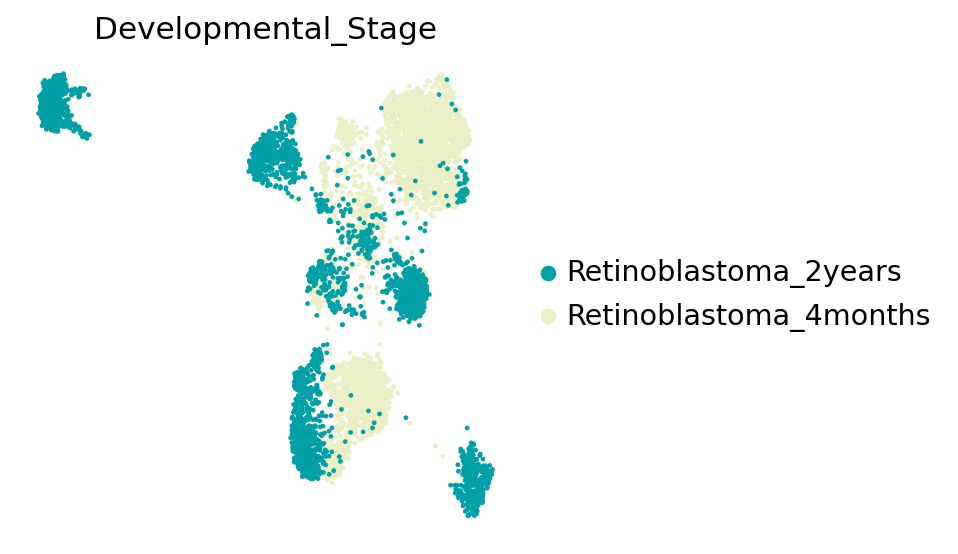

In [19]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='Developmental_Stage',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

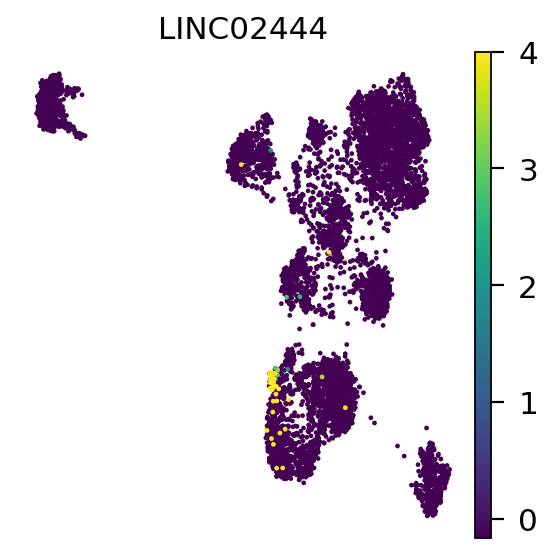

In [20]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['LINC02444'],
    title='LINC02444',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

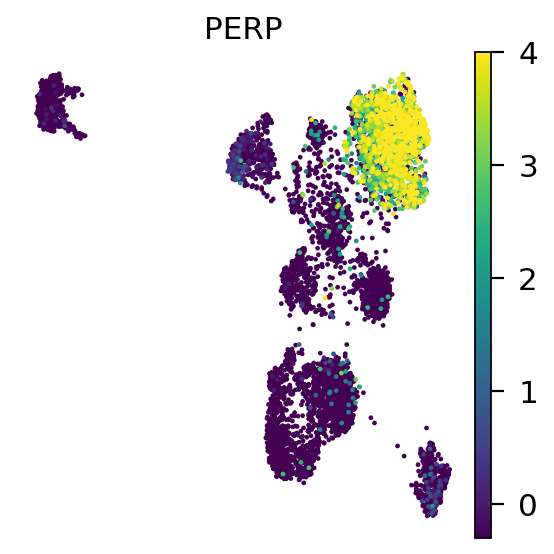

In [21]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['PERP'],
    title='PERP',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

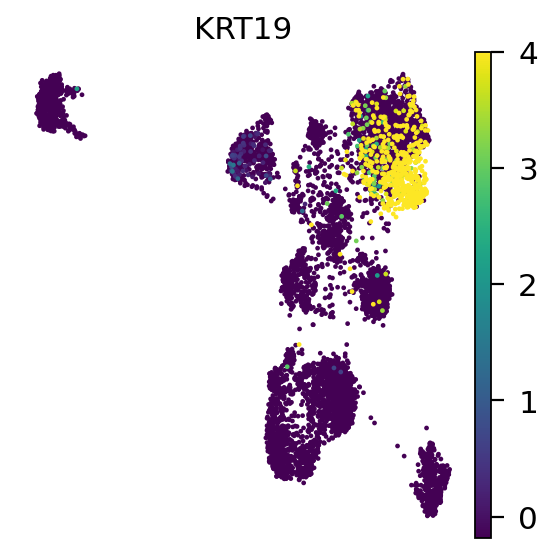

In [23]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['KRT19'],
    title='KRT19',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

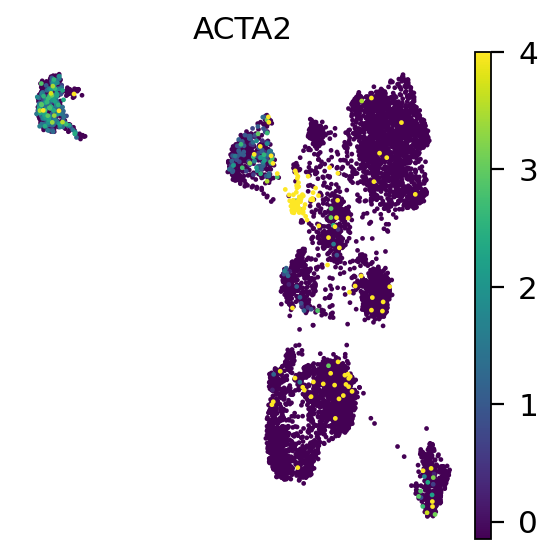

In [26]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['ACTA2'],
    title='ACTA2',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

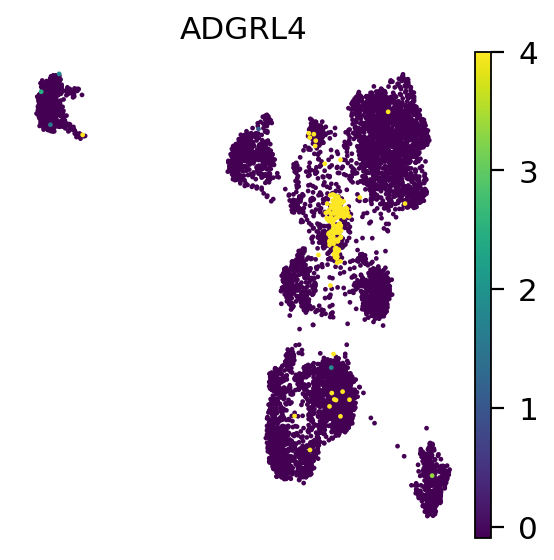

In [25]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['ADGRL4'],
    title='ADGRL4',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

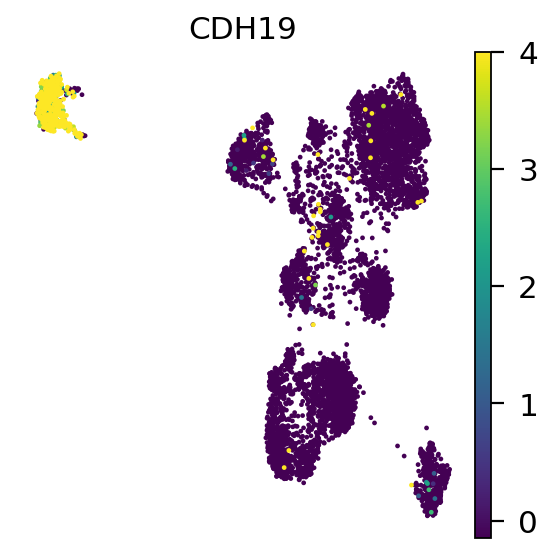

In [27]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['CDH19'],
    title='CDH19',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

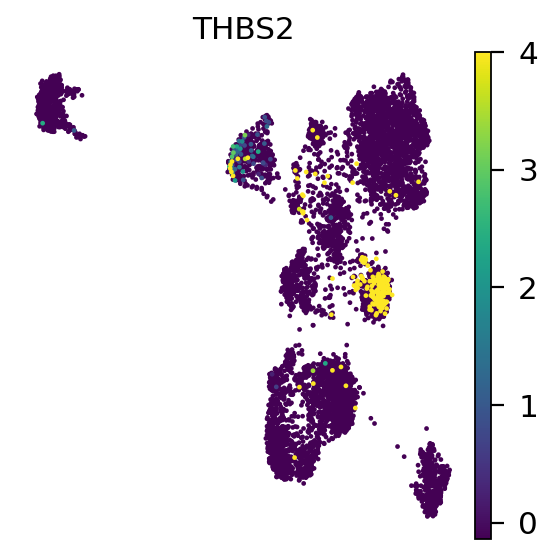

In [40]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['THBS2'],
    title='THBS2',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

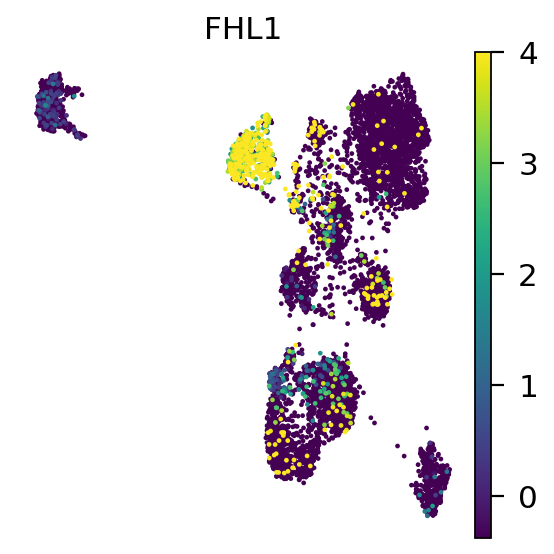

In [29]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['FHL1'],
    title='FHL1',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

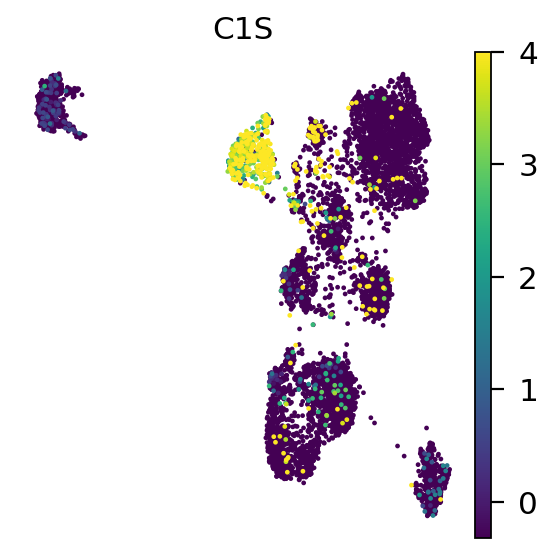

In [30]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['C1S'],
    title='C1S',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

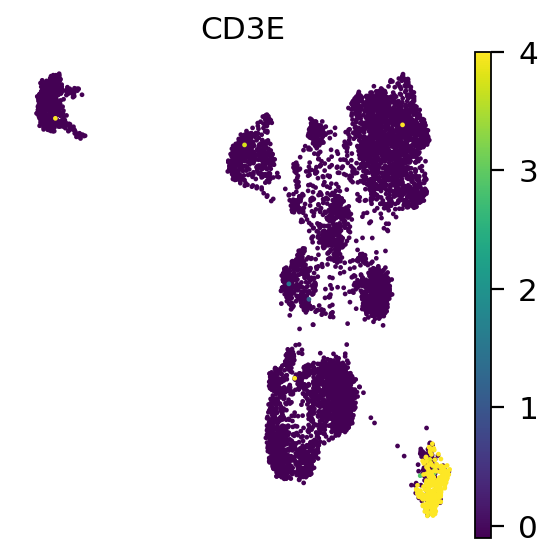

In [31]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['CD3E'],
    title='CD3E',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

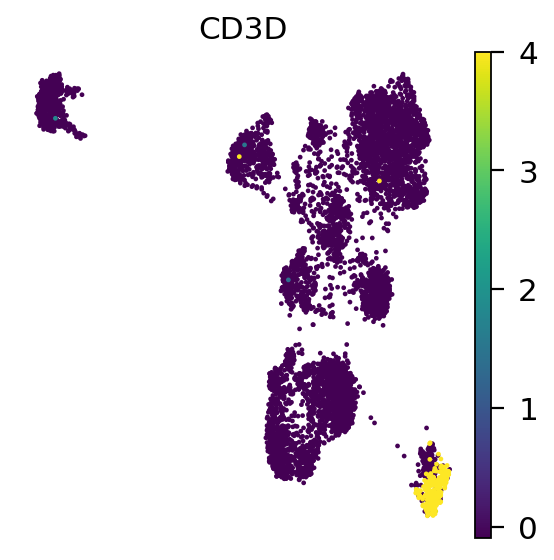

In [32]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['CD3D'],
    title='CD3D',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

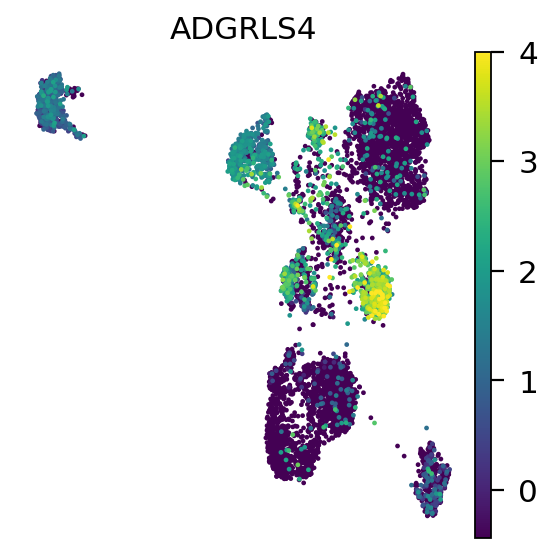

In [33]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['LGALS1'],
    title='ADGRLS4',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

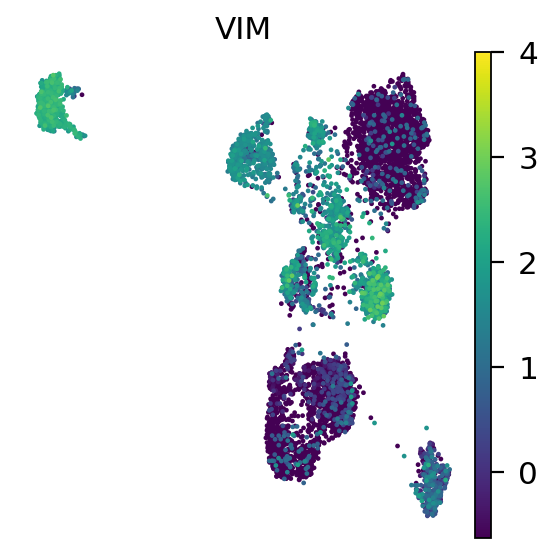

In [34]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['VIM'],
    title='VIM',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

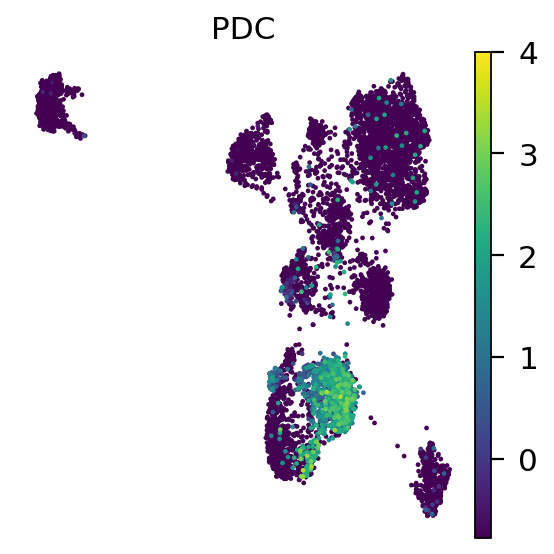

In [35]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['PDC'],
    title='PDC',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

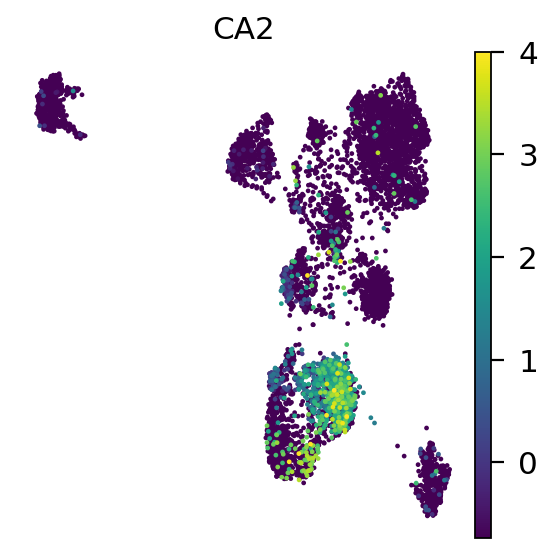

In [37]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['CA2'],
    title='CA2',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

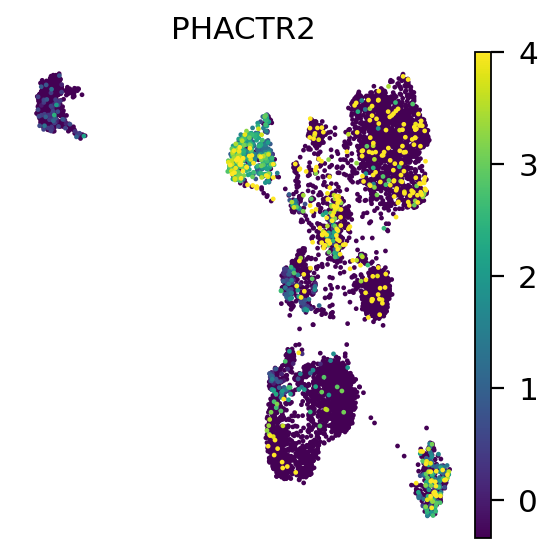

In [38]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['PHACTR2'],
    title='PHACTR2',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

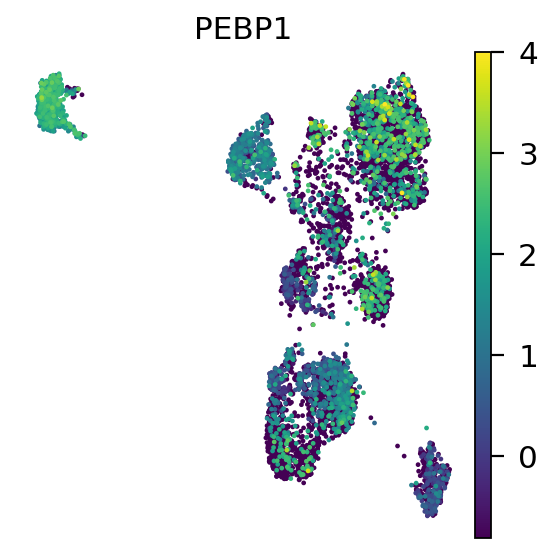

In [39]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['PEBP1'],
    title='PEBP1',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

In [41]:
adata.obs['major_celltype'].unique()

['Müller glia cells', 'Astrocytes', 'Lymphocytes', 'Retinal pigment epithelium (RPE) cells']
Categories (4, object): ['Astrocytes', 'Lymphocytes', 'Müller glia cells', 'Retinal pigment epithelium (RPE) cells']

In [42]:
# create a dictionary to map cluster to annotation label
#Müller glia cells(MGC)
cluster2annotation = {
     '0': 'Astrocytes CLU+',
     '1': 'fibrous Astrocytes',
     '2': 'Astrocytes PHACTR1+',
     '3': 'MGC-Normal',
     '4': 'Microglial cells',
     '5': 'MGC-Profiled',
     '6': 'T cells',
     '7': 'MGC-Immune',
     '8': 'Dendritic cells',
     '9': 'foot process Astrocytes',
     '10': 'Middle Glial cells',
     '11': 'MGC-Normal',
   


}
adata.obs['major_celltype1'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

2023-04-05 15:13:14.782853	Running VIA over input data of 6614 (samples) x 100 (features)
2023-04-05 15:13:14.782896	Knngraph has 20 neighbors
2023-04-05 15:13:17.394740	Finished global pruning of 20-knn graph used for clustering at level of 0.15. Kept 43.3 % of edges. 
2023-04-05 15:13:17.416096	Number of connected components used for clustergraph  is 1
2023-04-05 15:13:18.285879	Commencing community detection
2023-04-05 15:13:18.363830	Finished running Leiden algorithm. Found 295 clusters.
2023-04-05 15:13:18.365274	Merging 260 very small clusters (<10)
2023-04-05 15:13:18.367721	Finished detecting communities. Found 35 communities
2023-04-05 15:13:18.368041	Making cluster graph. Global cluster graph pruning level: 0.5
2023-04-05 15:13:18.380014	Graph has 1 connected components before pruning
2023-04-05 15:13:18.382172	Graph has 1 connected components after pruning
2023-04-05 15:13:18.382380	Graph has 1 connected components after reconnecting
2023-04-05 15:13:18.383083	1.1% links tri

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


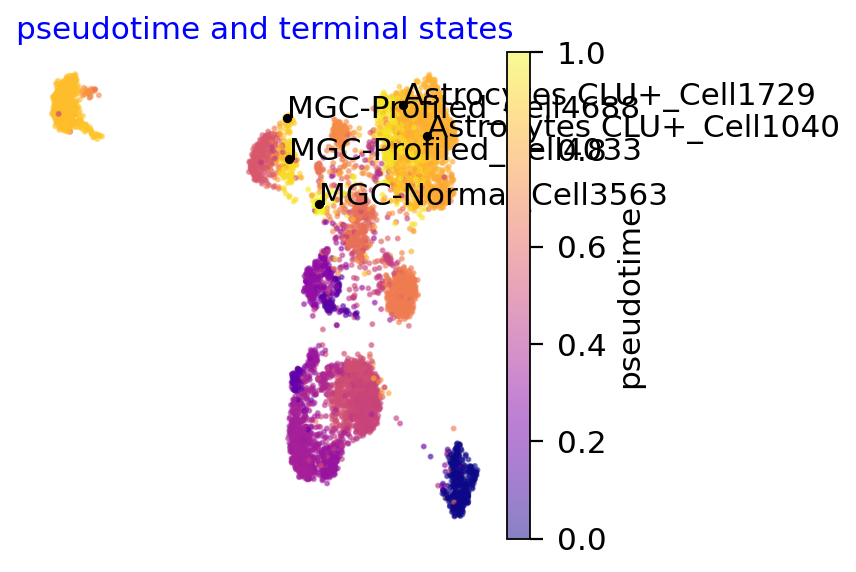

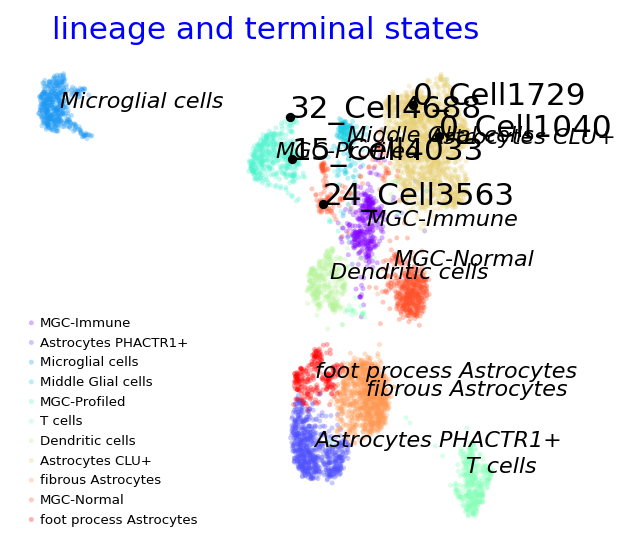

2023-04-05 15:13:26.516141	Time elapsed 10.5 seconds


In [43]:
jac_std_global = 0.15 #(smaller values increase granularity of clusters)
n_pcs = 100
knn = 20
cluster_graph_pruning_std = 0.5 #(smaller values remove more edges in the cluster graph)
v0_toobig = .3 #(clusters that form more than 30% of entire population will be re-clustered)
root = None # No user-defined guidance for finding initial state [63] is a suitable root cell index
dataset = ''
random_seed = 42
velo_weight=0.5 #weight given to velocity matrix from scvelo. 1-velo_weight is assigned to gene-gene kernel
embedding = adata.obsm['X_umap'][:, 0:2]
true_label = adata.obs['major_celltype1'].tolist()
velocity_matrix=adata.layers['velocity']
gene_matrix=adata.X
pca_loadings = adata.varm['PCs'] # this is optional and offers slight adjustment of the locations of cells based on velocity

#impute genes we want to use in gene-trends later
#gene_list_magic_short = ['Sst','Ins1','Ins2','Gcg','Ghrl']
#df_ = pd.DataFrame(adata.X.todense())
#df_.columns = [i for i in adata.var_names]
#df_ = df_[gene_list_magic_short]


v0 = via.VIA(adata.obsm['X_pca'][:, 0:n_pcs], true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
             too_big_factor=v0_toobig, root_user=root, dataset=dataset, random_seed=random_seed,
           is_coarse=True, preserve_disconnected=True, pseudotime_threshold_TS=50,
             cluster_graph_pruning_std=cluster_graph_pruning_std,
             piegraph_arrow_head_width=0.15,embedding = embedding,
             piegraph_edgeweight_scalingfactor=2.5, velocity_matrix=velocity_matrix,
                    gene_matrix=gene_matrix, velo_weight=velo_weight,  edgebundle_pruning_twice=False, edgebundle_pruning=0.15, pca_loadings = adata.varm['PCs']) # pca_loadings is optional #edge_bundling_twice = True would remove more of the edges
v0.run_VIA()

Text(0.5, 1.0, 'Pseudotime')

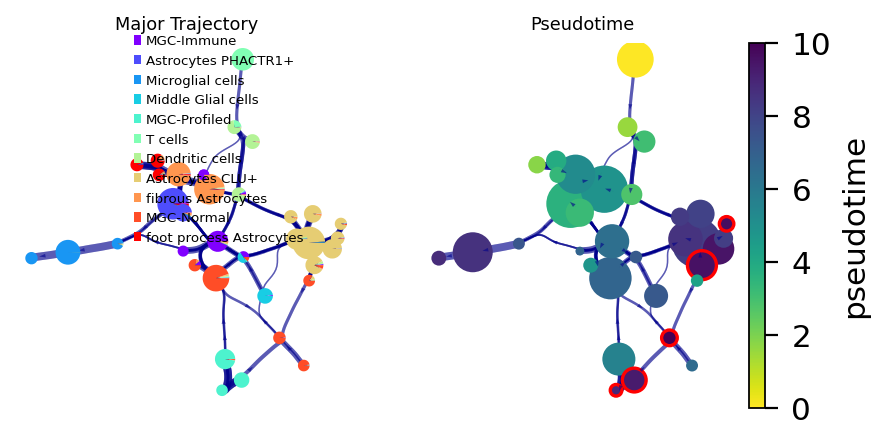

In [44]:
fig, ax, ax1 = via.draw_piechart_graph(via_object=v0,dpi=80,
                                       ax_text=False,fontsize=4)
fig.set_size_inches(6,3)
ax.set_title('Major Trajectory',fontsize=8)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=8)

In [45]:
adata.obs['major_celltype1'].cat.categories

Index(['Astrocytes CLU+', 'Astrocytes PHACTR1+', 'Dendritic cells',
       'MGC-Immune', 'MGC-Normal', 'MGC-Profiled', 'Microglial cells',
       'Middle Glial cells', 'T cells', 'fibrous Astrocytes',
       'foot process Astrocytes'],
      dtype='object')

KeyError: 'major_celltype1_colors'

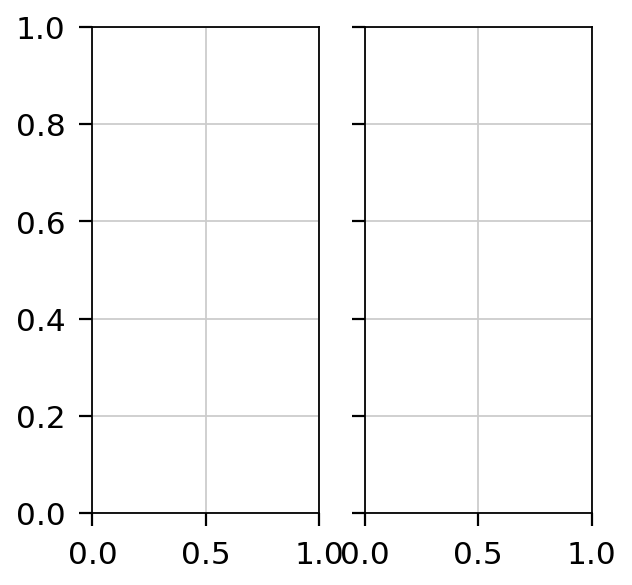

In [46]:
fig, ax, ax1 = draw_piechart_graph(adata=adata,clusters='major_celltype1',
                                   via_object=v0,cmap='Blues',dpi=80,
                                   show_legend=False,ax_text=False,fontsize=4)
fig.set_size_inches(8,4)
ax.set_title('Major Trajectory',fontsize=12)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=12)
plt.rcParams['axes.facecolor']='snow'

plt.savefig('result_4/P_tr.png',dpi=300,bbox_inches='tight')